# CS M148 Project 2 - Binary Classification Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a **patient is suffering from heart disease** based on a host of potential medical factors.

**DEFINITIONS**

**Binary Classification:** In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

**Supervised Learning:** This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
- **age:** Age in years
- **sex:** (1 = male; 0 = female)
- **cp:** Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)
- **trestbps:** Resting blood pressure (in mm Hg on admission to the hospital)
- **cholserum:** Cholestoral in mg/dl
- **fbs** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg:** Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))
- **thalach:** Maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeakST:** Depression induced by exercise relative to rest
- **slope:** The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)
- **ca:** Number of major vessels (0-4) colored by flourosopy
- **thal:** 1 = normal; 2 = fixed defect; 3 = reversable defect
- **sick:** Indicates the presence of Heart disease (True = Disease; False = No disease)

`sick` is the label that you will be predicting.

## Loading Essentials and Helper Functions 

In [ ]:
# Here are a set of libraries we imported to complete this assignment. 
# Feel free to use these or equivalent libraries for your implementation
# If you can run this cell without any errors, you're ready to go.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

import os
import itertools
import random 

%matplotlib inline

random.seed(148) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's load our dataset so we can work with it (correct the path if your notebook is in a different directory than the .csv file).

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project2_14_Oct_2021.zip (Unzipped Files)/heartdisease.csv')

### Question 1.1 

Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method, the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [ ]:
# Head Method
data.head(8)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,False
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,False
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,False


In [ ]:
# Describe Method
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [ ]:
# Info Method
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


### Question 1.2
Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

**sick**: Boolean format may provide issues for our learning methods and should be changed to integers of 0 or 1 instead

### Question 1.3
Determine if we're dealing with any null values. If so, report which columns.

In [ ]:
data.isnull().sum()
# There are no null values in any columns

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

### Question 1.4
Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean `sick` variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original `sick` datafield from the dataframe.

In [ ]:
# Change sick column from bool to int
data['sick'] = data['sick'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
# Drop 'sick' column from copy of data and store in X
X = data.drop(['sick'], axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


### Question 1.5
Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to get a feel of how each variable performs (for example, is it a binary, or limited selection, or does it follow a gradient)? 

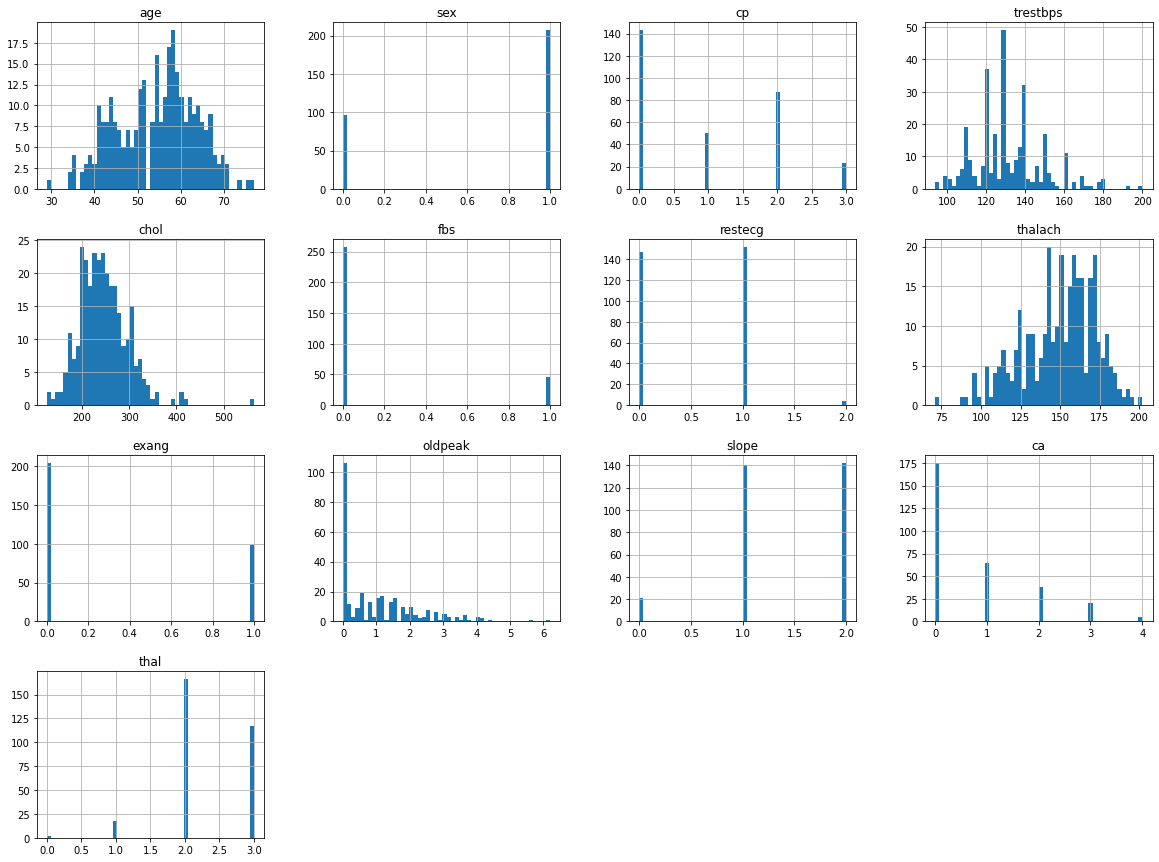

In [ ]:
X.hist(bins=50, figsize=(20,15))
plt.show()

# Numeric: Age, Trestbps, chol, thalac, oldpeak
#   Age exhibit the most normal behavior
#   trestbps and chol exhibit a slight right skew
#   oldpeak exhibits a major right skew
#   thalach exhibits a slight left skew
# Binary: Sex, fbs, exang, 
# Categorical (w/ gradient): ca
# Categorical (w/o gradient): cp, restecg, slope, thal

### Question 1.6
We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results.

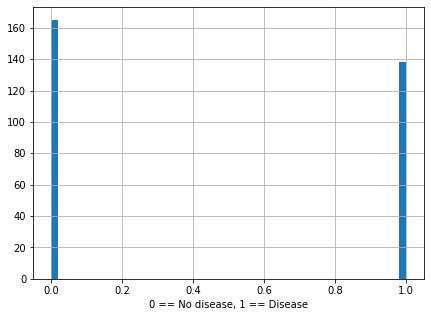

In [ ]:
# Generates histogram of sick data
data['sick'].hist(bins=50, figsize=(7,5))
plt.xlabel("0 == No disease, 1 == Disease")
plt.show()

In [ ]:
# Displays counts of sick and healthy individuals
data['sick'].value_counts()

0    165
1    138
Name: sick, dtype: int64

As we can see, our sample contains 165 healthy individuals and 138 sick individuals, which reflects a slightly imbalance dataset.

### Question 1.7 
Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

- If original dataset is not balanced, will only increase error
- If original dataset is not balanced, actual features may be ignored via arbitrary imbalance
- If augmentation is used to moderate imbalances, original issues could simply be magnified


### Question 1.8
Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations (get some domain knowledge). Intuitively, why do you think some variables correlate more highly than others? Also discuss some pairs of variables that have very little correlation and why this might be the case for them.

Hint: one possible approach you can use the `sns.heatmap()` function to map the corr() method. Note: if your heatmap is not entirely visible, [this link](https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986) may be helpful in solving the issue.

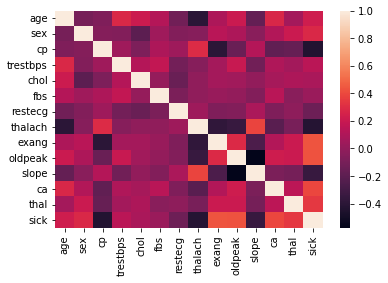

In [ ]:
# Load library for making heatmap from correlation matrix
import seaborn as sns

# Create correlation matrix across
corrMat = data.corr(method='pearson')

# Create heatmap of correlation matrix
sns.heatmap(corrMat,xticklabels=corrMat.columns,yticklabels=corrMat.columns)

# Features with positive correlation: 
#   thalach with cp (slightly pos) - Angina is a condition marked by a low 
#     blood supply to the heart, so it makes sense that the max heart rate is
#     higher because it must pump harder in order to maintain the same blood 
#     outflow
#   slope with thalach - 
#   sick with exang, oldpeak, ca
#
# Features with negative correlation: 
#   thalach with age
#   exang with cp, thalach
#   slope with oldpeak
#   sick with cp, thalach, slope
#
# Notable features with no correlation

###Features with positive correlation: 
**thalach with cp (slightly pos)** - Angina is a condition marked by a low blood supply to the heart, so it makes sense that the max heart rate is higher because it must pump harder in order to maintain the same blood outflow

**slope with thalach** - For a typical individual, an upslope is common following peak exercise, just as a high heart rate is

**sick with exang, oldpeak, ca** - Exercise-induced angina, exercise-induced depression, and more colored vessels are all symptoms of heart disease

### Features with negative correlation: 
**thalach with age** - A person's heart naturally slows with age, so a negative correlation makes sense

**exang with thalach** - A person with exercise-induced angina likely has a weaker heart than a healthy person, so a negative correlation makes sense

**slope with oldpeak** - A downslope correlates to higher exercise-induced depression possibly because of some underlying confounding variable

**sick with cp, thalach, slope** - Chest pain, maximum heart rate, and an upsloping peak ST segment all correlate negatively with Heart Disease likely because this particular Heart Disease may only be activated during moments of exercise


### Notable features with no correlation
**cholserum with trestbps** - Normally high blood pressure and high cholestoral are strongly correlated, but it is odd that they are not in this dataset

## Part 2. Prepare the Data

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

We're going to ask you to prepare 2 batches of data:
1. Raw numeric data that hasn't gone through any additional pre-processing.
2. Data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1
Save the target column as a separate array and then drop it from the dataframe. 

In [ ]:
Y = data['sick']
X = data.drop(labels=['sick'],axis = 1)

### Question 2.2
Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 85% of your total dataframe (hint: use the `train_test_split` method). Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [ ]:
# Splits predcitor variables (X) and response variable (Y) into training and 
# testing with an 85/15 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 148)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(257, 13)
(46, 13)
(257,)
(46,)


### Question 2.3
In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN rlies on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a KNN algorithm on our data (use `scikit-learn`) and report the results. For this initial implementation simply use the default settings. Report on the accuracy of the resulting model.

In [ ]:
knnPred = KNeighborsClassifier()
knnPred.fit(X_train,Y_train)
print("kNN default accuracy:",knnPred.score(X_test, Y_test))
# The accuracy for the model resulting from the default settings of the kNN 
# is roughly 78.3%

kNN default accuracy: 0.782608695652174


### Question 2.4 
Now implement a pipeline of your choice to transform the data. You can opt to handle null values and categoricals however you wish, however please scale your numeric features using standard scaler. Refer to Project 1 for a example pipeline that you can mimic.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Step 1: Drop unnecessary (and categorical) columns before creating the pipeline
data_num = data.drop(['thal', 'restecg', 'sick'], axis=1) 

# Step 1.1: Augment Features
trestbps_ix, cholesterol_ix = 4, 5

# 
class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    implements the following features 
    data["bps_chol"] = data["trestbps"]*data["cholesterol"]
    '''
    def __init__(self, add_bps_chol = True): 
        self.add_bps_chol = add_bps_chol
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.add_bps_chol:
            bps_chol = X.iloc[:, trestbps_ix] * X.iloc[:, cholesterol_ix]
            return np.c_[X, bps_chol]
        else:
            return np.c_[X]

# Step 2: Create a custom pipeline for the df with dropped columns
num_pipeline = Pipeline([
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler())
    ])

# Step 3: Remove categorical features from the numeric values
numerical_features = list(data_num) # Include all numerical features
categorical_features = ['thal', 'restecg'] # Include all categorical features
# At this point, only useful categorical and numerical data are still in the df

# Step 4: Create a pipeline to transform all numerical columns (StandardScaler()) and categorical columns (OneHotEncoder())
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features),
    ])

### Question 2.5
Now split your pipelined data into an 85/15 split and run the same KNN as you did previously. Report its accuracy, and discuss the implications of the different results you are obtaining.

In [ ]:
# Step 5: Fit_transform the training data into the pipeline
X_train_pipe = full_pipeline.fit_transform(X_train)

# Step 6: Transform test data based on fitted parameters from training data 
X_test_pipe = full_pipeline.transform(X_test)

knnPred = KNeighborsClassifier()
knnPred.fit(X_train_pipe,Y_train)
print("kNN default accuracy:",knnPred.score(X_test_pipe, Y_test))
# The accuracy for the model resulting from the default settings of the kNN 
# is roughly 80.4%. The only changes made between the raw data and the pipelined 
# data are the additional column and the StandardScaler(). Therefore, one of
# these additions contributed to the increased accuracy of the model.

kNN default accuracy: 0.8043478260869565


### Question 2.6 Hyperparameter Optimization
As we saw in lecture, the KNN Algorithm includes an `n_neighbors` attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now letting `n` take on the values 1, 2, 3, 5, 7, 9, 10, 20, 50, 75, and 100. Run your model for each value and report the accuracy for each. Then, create a plot of accuracy versus `n_neighbors` and discuss how and why the accuracy changes as `n_neighbors` changes.

HINT: leverage Python's ability to loop to run through the array and generate results so that you don't need to manually code each iteration.

n: Accuracy
2: 0.7608695652173914
3: 0.8043478260869565
5: 0.8043478260869565
7: 0.8260869565217391
9: 0.782608695652174
10: 0.8260869565217391
20: 0.8478260869565217
50: 0.8043478260869565
75: 0.8043478260869565


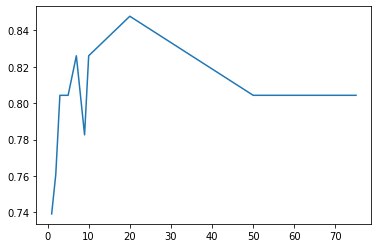

In [ ]:
n_vals = [1, 2, 3, 5, 7, 9, 10, 20, 50, 75]
acc_vals = []

for i in n_vals:
  knnPred = KNeighborsClassifier(n_neighbors=i)
  knnPred.fit(X_train_pipe,Y_train)
  acc_vals.append(knnPred.score(X_test_pipe, Y_test))

print("n: Accuracy\n=====================")
for i in range(1,10):
  strOut = str(n_vals[i]) + ": " + str(acc_vals[i])
  print(strOut)

plt.plot(n_vals,acc_vals)

# The accuracy differs for each because a different amount (k) of nearest 
# neighbors are used to determine an average. Since neither the data nor model
# exhibit a perfect linear fit, this value will vary across different values 
# of k

## Part 3. Additional Learning Methods
So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare results. Throughout this part, use the data that was produced by your pipeline earlier.

### Linear Decision Boundary Methods
We'll spend some time exploring logistic regression and SVM methods.

### Question 3.1 Logistic Regression
Let's now try a classifier, we introduced in lecture, one that's well known for handling linear models: logistic regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.  Implement a logistic regression classifier on your data with the default settings. Report accuracy, precision, recall, and F1 score and plot a confusion matrix.

Accuracy:    0.847826
Precision:   0.850000
Recall:      0.809524
F1 Score:    0.829268


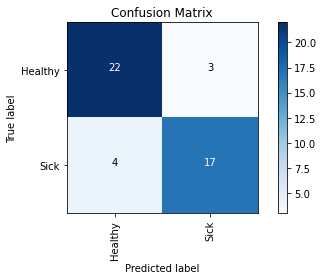

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_pipe, Y_train)
predicted = log_reg.predict(X_test_pipe)
score = log_reg.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted)))

draw_confusion_matrix(Y_test, predicted,['Healthy', 'Sick'])

### Question 3.2
Discuss what each measure (accuracy, precision, recall, and F1 score) is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.


**Definitions**: 
*   True Positive (TP): The amount of instances where the model correctly scored category 0
*   True Negative (TN): The amount of instances where the model correctly scored category 1
*   False Positive (FP):The amount of instances where the model incorrectly scored category 0
*   False Negative (FN): The amount of instances where the model incorrectly scored category 1

**Accuracy**:
* Description: (TP+TN)/(TP+TN+FP+FN); The amount of correct guesses divided by the total number of guesses
* Significance: Useful when dataset is relatively balanced between 2 classes 
* Examples: A model which tries to predict whether a fair coin will land on heads or tails

**Precision**: 
* Description: (TP) / (TP + FP); The amount of correct positives out of all the positives predictions
* Significance: Useful when considering a model with major class imbalance and a larger amount of actual positives than actual negatives 
* Examples: A model which tries to diagnosis a rare disease (TP) based on a number of biological factors.

**Recall**:
* Description: (TP) / (TP + FN); The amount of correct positives out of all the actual positives
* Significance: Useful when considering a model with major class imbalance and a larger amount of actual negatives than actual positives
* Examples: A model which tries to predict whether or not a credit card transaction was fraudulent (TP).

**F1 Score**:
* Description: (2*Recall)(Precision)/(Recall + Precision); The arithmetic mean of recall and precision
* Significance: Useful when considering a model with any class imbalance
* Examples: A model which tries to predict whether or not a credit card transaction was fraudulent (TP).

**Scenarios of Different Metric Values**:
In general, if a model's classes are balanced, then accuracy is a quick and simple metric which can reflect performance well. However, when there is any form of major class imbalance, an F1 Score should be used for anomaly detection. 

### Question 3.3
Graph the ROC curve of the logistic regression model.

Text(0.5, 1.0, 'ROC Curve with Logistic Regression')

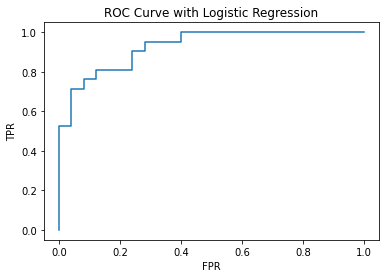

In [ ]:
fpr_log, tpr_log, thresholds = metrics.roc_curve(Y_test, score[:], pos_label=1)

plt.plot(fpr_log, tpr_log)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with Logistic Regression')

### Question 3.4
Describe what an ROC curve is and what your ROC graph output is showing.

An ROC Curve plots False Positive Rate (FPR) against True Positive Rate (TPR) at different classification thresholds. 
* FPR = FP / (FP + TN)
* TPR = TP / (TP + FN)

FPR is the amount of false positives over the total amount of total actual negatives.

TPR is the amount of true positives over the total of total actual positives.

Our ROC Graph is showing how truly correct the model is, accounting for class imbalances. The closer the area under the ROC curve is to 1, the better equipped the model is to account for class imbalances.

### Question 3.5
Let's tweak a few settings. Set your solver to `newton-cg`, your `max_iter=4`, and `penalty='none'`, and rerun your model. Report out the same metrics (the 4 + confusion matrix) as before. How do your results change?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Accuracy:    0.847826
Precision:   0.850000
Recall:      0.809524
F1 Score:    0.829268


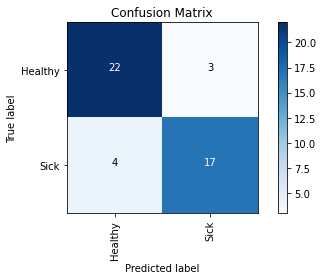

In [ ]:
log_reg_new = LogisticRegression(penalty='none', solver = 'newton-cg', max_iter=4)
log_reg_new.fit(X_train_pipe, Y_train)
predicted = log_reg_new.predict(X_test_pipe)
score = log_reg_new.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted)))

draw_confusion_matrix(Y_test, predicted,['Healthy', 'Sick'])

# All of my results remained the same

### Question 3.6
Did you notice that when you ran the previous model you got the following warning: `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge.` Check the documentation and see if you can implement a fix for this problem, and again report your results.

Note: if you did not get a warning, which might happen to those running this notebook in VSCode, please try running the following code, as described [here](https://github.com/microsoft/vscode-jupyter/issues/1312):
```
import warnings
warnings.simplefilter(action="default")
```

Accuracy:    0.826087
Precision:   0.809524
Recall:      0.809524
F1 Score:    0.809524


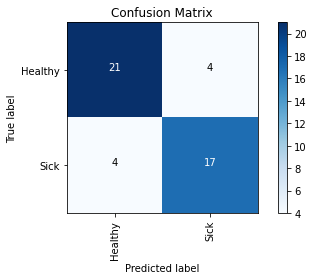

In [ ]:
log_reg_new = LogisticRegression(penalty='none', solver = 'newton-cg', max_iter=100)
log_reg_new.fit(X_train_pipe, Y_train)
predicted = log_reg_new.predict(X_test_pipe)
score = log_reg_new.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted)))

draw_confusion_matrix(Y_test, predicted,['Healthy', 'Sick'])

# Precision and F1 Score decreased to the value of Recall from the previous 
# attempts

### Question 3.7
Explain what you changed and why this fixed the `ConvergenceWarning` problem. Are there any downsides of your fix? How might you have harmed the outcome instead? What other parameters you set may be playing a factor in affecting the results?

I increased max_iter from 4 to 100, which allows the solver to converge on a final set of predictions by increasing its confidence. 

The downside to this fix is that runtime may increase for larger datasets due to the fact that the model will be able to iterate many more times before terminating. 

I may have harmed the outcome by overfitting the data via too many iterations. 

Changing penalty from its default 'l2' to 'none' and solver from its default 'lbfgs' to 'newton-cg' may also be contributing to this lower performing model. 

### Question 3.8
Rerun your logistic classifier, but modify the `penalty='l1'`, `solver='liblinear'` and again report the results.


Accuracy:    0.847826
Precision:   0.850000
Recall:      0.809524
F1 Score:    0.829268


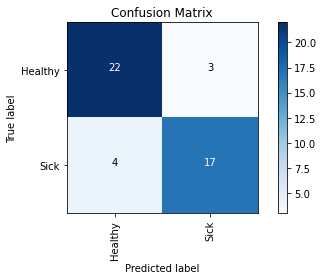

In [ ]:
log_reg_new = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter=100)
log_reg_new.fit(X_train_pipe, Y_train)
predicted = log_reg_new.predict(X_test_pipe)
score = log_reg_new.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted)))

draw_confusion_matrix(Y_test, predicted,['Healthy', 'Sick'])

### Question 3.9
Explain what what the two solver approaches are, and why the model with `liblinear` and `l1` penalty likely produced the optimal outcome.

* **newton-cg**: Good for multiclass problems, but only supports 'l2' and 'none' for penalties; Tracks the *Newton-Conjugate Gradient Procedures*, which is a gradient descent method of classification.
* **liblinear**: Good for small datasets, and supports 'l1' and 'l2' for penalties; Utilizes the *Library for Large Linear Classification*, which is a coordinate descent method of classification and works well for logistic regression

The liblinear method likely works better because it makes a binary decision based on a linear combination of training characteristics while the newton-cg method make a multi-class decision.

The 'l1' penalty limits the size of coefficients and can even set coefficients to 0, whereas the 'l2' penalty will change coefficients by the same factor and 'none' would set no limits to the size of coefficients.

Since our model is trying to make a binary classification using many predictor variables, it makes sense that 'liblinear' and 'l1' produce the most optimal outcome.

### Question 3.10
We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and the difference between L1 and L2 penalties.

The purpose of a penalty term is to limit the impact of each coefficient in a highly multi-dimensional model. This allows certain (low-impact) variables to have their coefficients shrunk to very small scalar values (or even to 0). In a model with many predictor variables, this can enhance performance by ignoring irrelevant variables.

**l1 penalty**: A penalty where the size of all coefficients is limited and can even reach 0, thus eliminating low-impact predictor variables.

**l2 penalty**: A penalty where all coefficients are shrunk by the same factor (but not eliminated).

The key difference between l1 and l2 penalties is that l1 penalties can result in the elimination of predictor variables whereas l2 penalties cannot.

### Question 3.11 Support Vector Machine (SVM)

A support vector machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In 2-D space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

Implement an SVM classifier on your pipelined data (recommend using `scikit-learn`) For this implementation you can simply use the default settings, but set `probability=True`.

In [ ]:
# Defines and fits a SVM classifier on the pipelined data
svm_class = SVC(probability=True)
svm_class.fit(X_train_pipe, Y_train)
predicted_svm = svm_class.predict(X_test_pipe)
score = svm_class.predict_proba(X_test_pipe)[:,1]

### Question 3.12 
Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

Accuracy:    0.847826
Precision:   0.888889
Recall:      0.761905
F1 Score:    0.820513


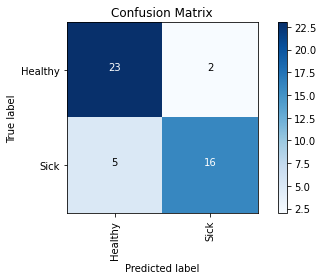

In [ ]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted_svm)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted_svm)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted_svm)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted_svm)))

draw_confusion_matrix(Y_test, predicted_svm,['Healthy', 'Sick'])

### Question 3.13
Rerun your SVM, but now modify your model parameter kernel to be `linear`. Again report your accuracy, precision, recall, F1 scores, and confusion matrix and plot the new ROC curve.  

Accuracy:    0.847826
Precision:   0.850000
Recall:      0.809524
F1 Score:    0.829268


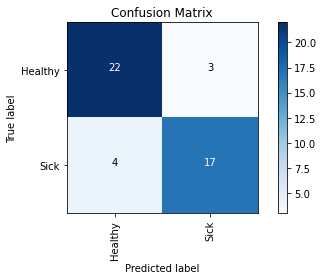

Text(0.5, 1.0, 'ROC Curve with Support Vector Machine')

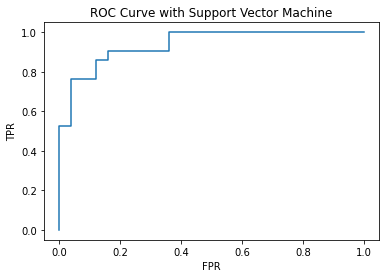

In [ ]:
# Defines and fits a new SVM classifier on the pipelined data
svm_class = SVC(kernel='linear', probability=True)
svm_class.fit(X_train_pipe, Y_train)
predicted_svm = svm_class.predict(X_test_pipe)
score = svm_class.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted_svm)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted_svm)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted_svm)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted_svm)))

draw_confusion_matrix(Y_test, predicted_svm,['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(Y_test, score[:], pos_label=1)

plt.plot(fpr_svm, tpr_svm)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with Support Vector Machine')

### Question 3.14
Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

These new results have a lower Precision (0.85 vs 0.888889), a higher Recall (0.809524 vs 0.761905), and a higher F1 Score (0.829268 vs 0.820513). This lower precision means that the model now classifies less TP or more FP. The higher recall means that the model now classifies more TP or less FN. The higher F1 score means that the model better addresses the presence of class imbalance in the dataset. 

The default argument for kernel is 'rbf' (Radial Basis Function), which is very similar to the kNN classification algorithm. Our newly supplied argument for kernel, 'linear', essentially attempts to draw a line through the data. This serves to divide the dataset into 2 groups: True and False. Although it is called 'linear', this kernel method is much more similar to a logistic regression method than the kNN-similar, 'rbf'.

### Question 3.15
Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. How do they differ in how they try to find this boundary?


Linear SVM tries to generate a linear decision boundary in such a way to maximize the net distance between the 2 classes. Logistic Regression tries to generate a linear decision boundary based on a sigmoid function.

### Question 3.16
We also learned about linear regression in class. Why is linear regression not a suitable model for this classification task?

Both Logistic Regression and Linear Regression will map a set of predictor variables, X, to an outcome variable Y. In logistic regression, this Y is over a discrete range. For this particular problem, [0 1]. However, in linear regression, this Y is over a continuous range of real numbers. For this classification task, we are not interested in any values between 0 and 1, but rather only the value sof 0 and 1 themselves.   

### Statistical Classification Methods
Now we'll explore a statistical classification method, the naive Bayes classifier.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. Bayes' theorem states the following relationship, given class variable $C_k$ and dependent feature vector
 
$$ {x} = [x_1, x_2, ..., x_n]^T$$, 
$$P(C_k | {x}) = \frac{P(C_k)P({x} | C_k)}{P({x})}$$

Note for our purposes, there are 2 possible classes (sick or not sick), so $k$ ranges from 1 to 2.

### Question 3.17
Implement a naive Bayes Classifier on the pipelined data. Use the `GaussianNB` model. For this model, simply use the default parameters. Report out the number of mislabeled points that result (i.e., both the false positives and false negatives), along with the accuracy, precision, recall, F1 Score and confusion matrix. Also, plot an ROC curve.

Accuracy:    0.739130
Precision:   0.846154
Recall:      0.523810
F1 Score:    0.647059


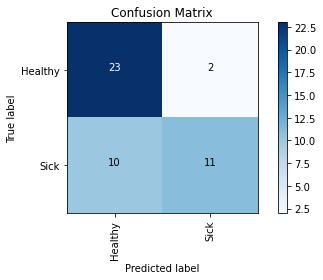

Number of mislabeled points:
False Positive: 10.000000
False Negative: 2.000000
Total Mislabeled: 12.000000



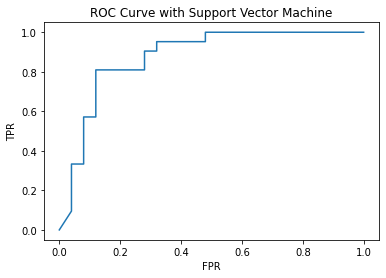

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_class = GaussianNB()
gnb_class.fit(X_train_pipe, Y_train)
predicted_gnb = gnb_class.predict(X_test_pipe)
score = gnb_class.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted_gnb)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted_gnb)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted_gnb)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted_gnb)))

draw_confusion_matrix(Y_test, predicted_gnb,['Healthy', 'Sick'])

fpr_gnb, tpr_gnb, thresholds = metrics.roc_curve(Y_test, score[:], pos_label=1)

plt.plot(fpr_gnb, tpr_gnb)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with Support Vector Machine')

# Get the number of TN, FP, FN, and TP
out = confusion_matrix(Y_test,predicted_gnb)

TN, FP, FN, TP = out[0][0], out[1][0], out[0][1], out[1][1]
print("Number of mislabeled points:\nFalse Positive: %f\nFalse Negative: %f\nTotal Mislabeled: %f\n" % (FP, FN, FP+FN))

### Question 3.18
Discuss the observed results. What assumptions about our data are we making here and why might those be inaccurate?

In [ ]:
len(data['age'].unique())

41

Assumptions: 
1. All of the predictor variables are independent of each other
2. All of the predictor variables are categorical

Inaccuracies: 
1. In real life, predictor variables are virtually never independent. In this example, it is assumed that sex and cholesterol levels are independent. However, it has been proven that women have naturally higher cholesterol levels due to their increased amount of estrogen.
2. Several of the predictor variables are numerical, which would cause major issues in this Naive Bayes' Classifier due its nature. By attempting to predict P(x|Ck) for the 'age' variable, the model will have to consider 41 different scenarios for each Ck alone. This sparcity will likely lead to inaccuracies later on.

## Part 4: Cross Validation and Model Selection
You've sampled a number of different classification techniques, leveraging nearest neighbors, linear classifiers, and statistical classifiers. You've also tweaked with a few parameters for those models to optimize performance. Based on these experiments you should have settled on a particular model that performs most optimally on this dataset. Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the train-test split. To check this, we will conduct a K-fold cross validation of our top 2 performing models, assess their cumulative performance across folds (report accuracy, precision, recall, and F1 score), and determine the best model for our particular data.

### Question 4.1
Select your top 2 performing models and run a 10-Fold cross validation on both. Report your best performing model.


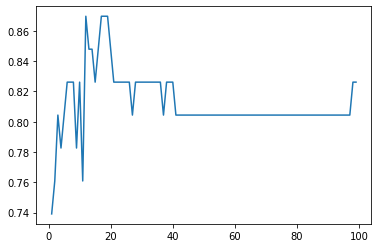

In [ ]:
# Since kNN had a high performance, I wanted to see if there were any k-values with a higher performance
n_vals = range(1,100)
acc_vals = []

for i in n_vals:
  knnPred = KNeighborsClassifier(n_neighbors=i)
  knnPred.fit(X_train_pipe,Y_train)
  acc_vals.append(knnPred.score(X_test_pipe, Y_test))

plt.plot(n_vals,acc_vals)

# It appears that k = 17, 18, and 19 all have an accuracy around 87%, so I will use an 18-NN classifier

In [ ]:
# Redefine X and Y in case they were earlier modified
Y = data['sick']
X = data.drop(labels=['sick'],axis = 1)

In [ ]:
# Model 1: kNN with n_neighbors = 18

knnPred = KNeighborsClassifier(n_neighbors=18)
scores = cross_val_score(knnPred, X, Y, cv=10)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.67 accuracy with a standard deviation of 0.07


In [ ]:
# Model 2: LogReg(penalty='l1', solver = 'liblinear', max_iter=100)

logReg = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter=100)
scores = cross_val_score(logReg, X, Y, cv=10)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.83 accuracy with a standard deviation of 0.06


Model 2: Logistic Regression with L1 Penalty and a Liblinear Solver has a higher accuracy and lower standard deviation than Model 1, so Model 2 is the higher performing model.

### Question 4.2
Discuss your results and why they differ slightly from what you got for the 2 models above.

My original accuracy for the 18-NN model was roughly 0.87 whereas my original accuracy for the Logistic Regression with a L1 Penalty and Lilinear classifier was roughly 0.85. Therefore, I expected similar performance during the crss-validation stage. However, I was surprised to find that the 18-NN model performed far worse (0.67) than the Logistic Regression model (0.83) during the cross-validation step. This is likely attributed to sampling bias because the data used to train and test the 18-NN model was structured particularly well whereas other train/test breaks were less ideal. The standard deviation of the 18-NN model (0.09) was alarminly large too, which further supports the motif of sampling bias in the original split.

### Question 4.3
Out of these 2 models, based on their scores for the 4 metrics, which one would you pick for this specific case of predicting if someone has heart disease or not?

In [ ]:
knnPred = KNeighborsClassifier(n_neighbors=18)
knnPred.fit(X_train_pipe, Y_train)
predicted_knn = knnPred.predict(X_test_pipe)
score = knnPred.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted_knn)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted_knn)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted_knn)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted_knn)))

Accuracy:    0.869565
Precision:   0.941176
Recall:      0.761905
F1 Score:    0.842105


In [ ]:
logReg = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter=100)
logReg.fit(X_train_pipe, Y_train)
predicted_log = logReg.predict(X_test_pipe)
score = logReg.predict_proba(X_test_pipe)[:,1]

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(Y_test, predicted_log)))
print("%-12s %f" % ('Precision:', metrics.precision_score(Y_test, predicted_log)))
print("%-12s %f" % ('Recall:', metrics.recall_score(Y_test, predicted_log)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(Y_test, predicted_log)))

Accuracy:    0.847826
Precision:   0.850000
Recall:      0.809524
F1 Score:    0.829268


Out of these 2 models, based on the metrics, I would choose the 18-Nearest Neighbor predictor since it has the higher accuracy and F1 Score. However, since it only had a 0.67 accuracy with a standard deviation of 0.09, this higher performance can be slightly attributed to random chance. Therefore, I would recommend the Logistic Regression model with an L1 penalty and a Liblinear solver for this specific case of predicting whether or not someone has heart disease